# Load Balancing Policies, Modeled by # of Keys in InMemoryDb

We want to show the need for dynamic load balancing policies. One basic policy is limit the size of the InMemoryDBs on the Parsplice nodes; a smaller cache hurts performance because key-value pairs need to be retrieved from other nodes and a larger cache has higher memory usage.

Implementation nodes: we limit the size of the InMemoryDB on the work manager by evicting the least recently used keys. For each transaction, check the size of the InMemoryDb and prune if necessary. We check every transaction instead of when segments complete because (1) the InMemoryDB fills up too fast, and (2) it reduces the overhead of key eviction.

In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
try: shutil.rmtree("tmp")
except: pass
os.mkdir("tmp")
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

**Parsplice: Active Keys** - # of keys receiving `get()` requests; Run 1 uses a lower particle growth rate
- Observation 1: small number of keys are active at any one time; the keyspace is 50K but less than 50 keys receive `get()` requests. 
- Observation 2: active keyspaces changes over time
- Observation 3: keyspace size can be controlled with Parsplice growth parameter
  
**Implementation Graphs**: ya... it works

In [2]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB", "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}
def untar(fname):
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
        #print "... parsing ", name, 
    #print "... done parsing !"
    return stats

In [3]:
dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Hour", "../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/"))
stats.append(parse(dfs, "Delay 100K", "../experiments/baseline-trinitite/nano/parmsweep/scale-delay-100000-60117"))
stats.append(parse(dfs, "Delay 1M",   "../experiments/baseline-trinitite/nano/parmsweep/scale-delay-1000000-60120"))

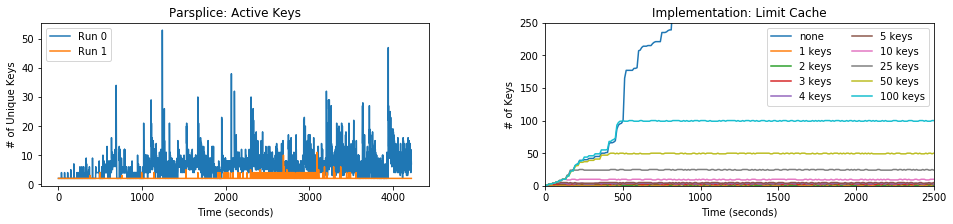

In [211]:
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, label="blah", ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    shift = np.min(df_u['ts']) * np.ones(len(df_u['ts']))
    ax.plot(df_u['ts'] - shift, df_u['count'], label=label)
    ax.set_title("Parsplice: Active Keys")
    ax.set_ylabel("# of Unique Keys")
    ax.set_xlabel("Time (seconds)")
    ax.legend()
    
def plot_keyspace(ax, op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    label = os.path.basename(results).split('-')[1]
    if label != "none":
        label = label + " keys"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")

fig, ax = plt.subplots(1, 2, figsize=(16, 3))
fig.subplots_adjust(wspace=0.3)
plot_uniquekeys_per_ts(ax[0], dfs, ("Delay 100K", "DBMemoryGet", "4"), "Run 0")
plot_uniquekeys_per_ts(ax[0], dfs, ("Delay 1M",   "DBMemoryGet", "4"), "Run 1")

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
for run in ["intpurge-none-69205", "intpurge-1-69059", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    plot_keyspace(ax[1], "DBMemoryMapSize", d+run)
ax[1].set_title("Implementation: Limit Cache") 
ax[1].set_ylim(0, 250)
ax[1].set_xlim(0, 2500)
ax[1].legend(ncol=2)
ax[1].set_ylabel("# of Keys")

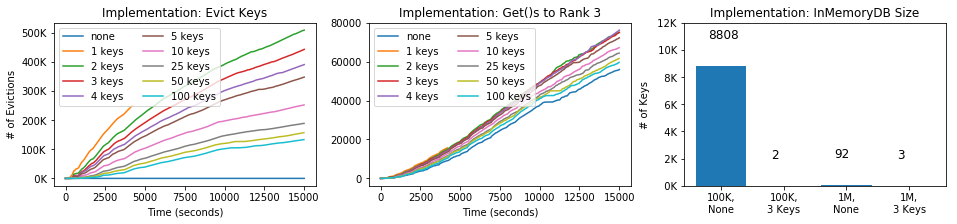

In [221]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
for run in ["intpurge-none-69205", "intpurge-1-69059", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    plot_keyspace(ax[0], "DBMemoryPurge", d+run)
ax[0].set_title("Implementation: Evict Keys")
ax[0].set_ylabel("# of Evictions")
ax[0].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[0].get_yticks()])
x = ax[0].legend(ncol=2)
 
def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.tail(1)['traj']

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
for run in ["intpurge-none-69205", "intpurge-1-69059", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    plot_keyspace(ax[1], "DBMemoryGet", d+run, rank="3")
ax[1].legend(ncol=2)
ax[1].set_title("Implementation: Get()s to Rank 3")

y = []; labels = []
d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
y.append(get_keyspace("DBMemoryMapSize", d+"intpurge-none-69205"))
y.append(get_keyspace("DBMemoryMapSize", d+"intpurge-3-69193"))
d = "../experiments/baseline-trinitite/nano/purge-keys-1hr-delay1M/"
y.append(get_keyspace("DBMemoryMapSize", d+"intpurge-none-69956"))
y.append(get_keyspace("DBMemoryMapSize", d+"intpurge-3-69959"))
x = np.arange(len(y))
ax[2].bar(x, y)
ax[2].set_ylim(0, 12000)
ax[2].set_xticks(range(0, len(x)))
ax[2].set_xticklabels(["100K,\nNone", "100K,\n3 Keys", "1M,\nNone", "1M,\n3 Keys"])
for i,j in zip(x,y):
    ax[2].annotate(int(j),xy=(i-0.2,int(j)+2000), fontsize=12)
ax[2].set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax[2].get_yticks()])
ax[2].set_title("Implementation: InMemoryDB Size")
x = ax[2].set_ylabel("# of Keys")

## Performance! 
We set a max memory limit to 4GB so the keyspace will be trimmed when we reach this threshold:

**100K vs. 1M Growth Rate**: higher trajectory length, (`y` axis) is better
- something happens at 1000 seconds for 100K

**100K Final Trajectory Length**: after running for 4 hours run
- performance variation, order of bars looks correct (bigger cache is better); is this noise?

TODO: ask Danny if we getting more "science" done?

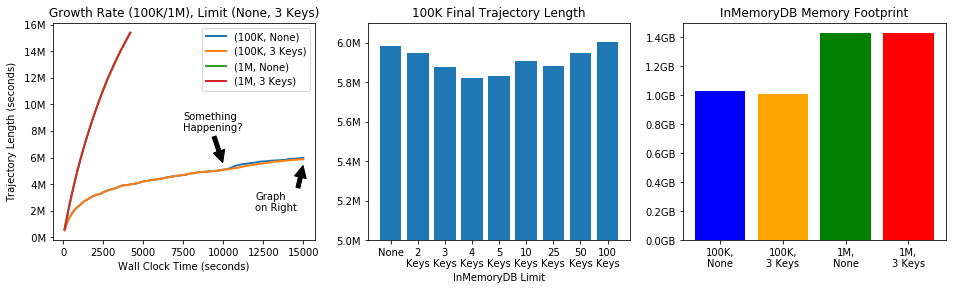

In [197]:
def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
    
def get_keyspace(op, results):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf.1", "tmp/perf.1")
    fname = "tmp/perf.1"
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    df_op['ts_shift'] = df_op['ts'] - shift
    return df_op[df_op['ts_shift'] == 4100.0]['count']

def get_mem(results):
    fname = ""
    if os.path.exists(results + "/out/mem.out"):
        fname = results + "/out/mem.out"
    else:
        untar(results + "/out/mem.out.tar.gz")
        shutil.move("mem.out", "tmp/mem.out")                
        fname = "tmp/mem.out"

    x = []; y = []; first = -1
    with open(fname) as f:
        for line in f:
            words = line.split(',')
            x.append(int(words[0]))
            y.append(int(' '.join(words[1].split()).split(' ')[2]))
    shift = x[0]*np.ones(len(x))
    return y[len(x) - 1]
    #ax.bar([x[len(x) - 1]], [y[len(x) - 1]], label=label)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
#fig.subplots_adjust(wspace=0.25)

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
plot_times(ax[0], "(100K, None)", d+"intpurge-none-69205")
plot_times(ax[0], "(100K, 3 Keys)",    d+"intpurge-3-69193")
d = "../experiments/baseline-trinitite/nano/purge-keys-1hr-delay1M/"
plot_times(ax[0], "(1M, None)",   d+"intpurge-none-69956")
plot_times(ax[0], "(1M, 3 Keys)",      d+"intpurge-3-69959")
ax[0].set_title("Growth Rate (100K/1M), Limit (None, 3 Keys)")
ax[0].set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax[0].get_yticks()])
ax[0].annotate('Something\nHappening?', xy=(10000, 5.5*1000*1000), xytext=(7500, 8*1000*1000),
               arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].annotate('Graph\non Right', xy=(15000, 5.5*1000*1000), xytext=(12000, 2*1000*1000),
               arrowprops=dict(facecolor='black', shrink=0.05))

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
y = []; labels = []
for run in ["intpurge-none-69205", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    l = run.split('-')[1]
    if l == "none": l = "None"
    else: l = l + "\nKeys"
    labels.append(l)
    y.append(get_max_traj(d+run))
ax[1].set_xticks(range(0, len(y)))
ax[1].set_xticklabels(labels)
ax[1].bar(np.arange(len(y)), y)
ax[1].set_ylim(5000000, 6100000)
ax[1].set_yticklabels(['{:3.1f}M'.format(yval/(1000*1000)) for yval in ax[1].get_yticks()])
ax[1].set_title("100K Final Trajectory Length")
ax[1].set_xlabel("InMemoryDB Limit")

y = []; labels = []
d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
y.append(get_keyspace("DBMemorySize", d+"intpurge-none-69205"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-3-69193"))
labels.append("100K,\nNone")
labels.append("100K,\n3 Keys")
#plot_times(ax[0], "(100K, Unlimited)", d+"intpurge-none-69205")
#plot_times(ax[0], "(100K, 3 Keys)",    d+"intpurge-3-69193")
d = "../experiments/baseline-trinitite/nano/purge-keys-1hr-delay1M/"
y.append(get_keyspace("DBMemorySize", d+"intpurge-none-69956"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-3-69959"))
labels.append("1M,\nNone")
labels.append("1M,\n3 Keys")

ax[2].bar(np.arange(len(y)), y, color=['blue', 'orange', 'green', 'red'])
ax[2].set_xticks(range(0, len(labels)))
ax[2].set_xticklabels(labels)
ax[2].set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax[2].get_yticks()])
x = ax[2].set_title("InMemoryDB Memory Footprint")

## Memory Usage for 100K

**Total Memory Footprint**: node-level memory usage, measured with `free`
- no memory savings for smaller keyspaces; in fact it's the opposite
- since all ranks are on the same node, the keyspace footprint savings may cause memory usage elsewhere

**InMemoryDB Memory Footprint**: memory used by the InMemoryDB, measured with performance counters
- no memory savings for smaller keyspaces

**Memory Footprint Over Time**: memory used over entirety of run (why is it growing?)

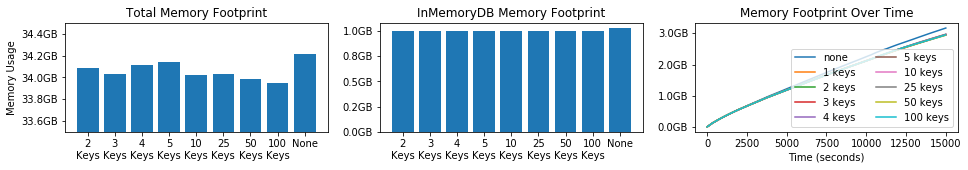

In [222]:
d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"


fig, ax = plt.subplots(1, 3, figsize=(16, 2))
#fig.subplots_adjust(wspace=0.25)
labels = []; y = []
labels.append("2\nKeys");
labels.append("3\nKeys");
labels.append("4\nKeys");
labels.append("5\nKeys");
labels.append("10\nKeys");
labels.append("25\nKeys");
labels.append("50\nKeys");
labels.append("100\nKeys");
labels.append("None")
y.append(get_mem(d+"intpurge-2-69192"))
y.append(get_mem(d+"intpurge-3-69193"))
y.append(get_mem(d+"intpurge-4-69194"))
y.append(get_mem(d+"intpurge-5-69196"))
y.append(get_mem(d+"intpurge-10-69197"))
y.append(get_mem(d+"intpurge-25-69199"))
y.append(get_mem(d+"intpurge-50-69200"))
y.append(get_mem(d+"intpurge-100-69201"))
y.append(get_mem(d+"intpurge-none-69205"))
ax[0].bar(np.arange(len(y)), y)
ax[0].set_ylim(33.5*1000*1000, 34.5*1000*1000)
ax[0].set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000)) for yval in ax[0].get_yticks()])
ax[0].set_title("Total Memory Footprint")
ax[0].set_xticks(range(0, len(labels)))
ax[0].set_ylabel("Memory Usage")
ax[0].set_xticklabels(labels)

y = []
y.append(get_keyspace("DBMemorySize", d+"intpurge-2-69192"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-3-69193"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-4-69194"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-5-69196"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-10-69197"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-25-69199"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-50-69200"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-100-69201"))
y.append(get_keyspace("DBMemorySize", d+"intpurge-none-69205"))
ax[1].bar(np.arange(len(y)), y)
ax[1].set_xticks(range(0, len(labels)))
ax[1].set_xticklabels(labels)
ax[1].set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax[1].get_yticks()])
x = ax[1].set_title("InMemoryDB Memory Footprint")

d = "../experiments/baseline-trinitite/nano/purge-keys-4hr/"
for run in ["intpurge-none-69205", "intpurge-1-69059", "intpurge-2-69192", "intpurge-3-69193", "intpurge-4-69194", "intpurge-5-69196", "intpurge-10-69197", "intpurge-25-69199", "intpurge-50-69200", "intpurge-100-69201"]:
    plot_keyspace(ax[2], "DBMemorySize", d+run)
ax[2].set_title("Memory Footprint Over Time") 
ax[2].legend(ncol=2)
x = ax[2].set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax[2].get_yticks()])